# RemoteImageFolder Implementation

This is the implementation and test for RemoteImageFolder. RemoteImageFolder is inherited from VisionDataset, it an ImageFolder class which can accept remote path. Right now for remote data, it only allows Pelican backend. And It also allow local path.

In [18]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import fsspec
from pelicanfs.core import PelicanFileSystem
import time
from PIL import Image
from fsspec.implementations.local import LocalFileSystem
from torchvision.datasets import VisionDataset
from torchvision.io import read_image
from PIL import Image
import matplotlib.pyplot as plt

class RemoteImageFolder(VisionDataset):

    def __init__(self, root,transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        if os.path.isdir(root):
            self._init_local(root)
        else:
            self._init_remote(root)

    def _init_local(self, root):
        print(f"Initializing local dataset from {root}")
        self.root = root
        self.fs = LocalFileSystem()
        self.classes = sorted(os.listdir(root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.imgs = self._make_dataset_local()

    def _init_remote(self, root, transform=None):
        self.root = root
        self.fs = PelicanFileSystem("pelican://osg-htc.org")
        
        self.classes = sorted([item['name'] for item in self.fs.ls(root)])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        self.imgs = self._make_dataset_remote()

    def _make_dataset_local(self):
        images = []
        for class_idx, cls_name in enumerate(self.classes):
            class_path = os.path.join(self.root, cls_name)
            if not os.path.isdir(class_path):
                continue
            for img_name in os.listdir(class_path):
                img_name = img_name.lower()
                if img_name.endswith('.jpg') or img_name.endswith('.jpeg') or img_name.endswith('.png'):
                    img_path = os.path.join(class_path, img_name)
                    images.append((img_path, class_idx))
        return images

    def _make_dataset_remote(self):
        images = []
        for class_idx, cls_name in enumerate(self.classes):
            class_path = os.path.join(self.root, cls_name)
            files = self.fs.ls(class_path)
            for item in files:
                img_path = item['name']
                if img_path.lower().endswith('.jpg') or img_path.lower().endswith('.jpeg') or img_path.lower().endswith('.png'):
                    images.append((img_path, class_idx))
        print("len(images): ", len(images))
        return images

    def __getitem__(self, index):
        img_path, target = self.imgs[index]
        if isinstance(self.fs, PelicanFileSystem): 
            with self.fs.open(img_path, 'rb') as f:
                img = Image.open(f).convert('RGB')
        else:
            img = read_image(img_path)
            img = transforms.ToPILImage()(img)
        
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, target

    def __len__(self):
        return len(self.imgs)


# Test Reading Remotely

Let we see whether the image transfer correctly.

len(images):  3925


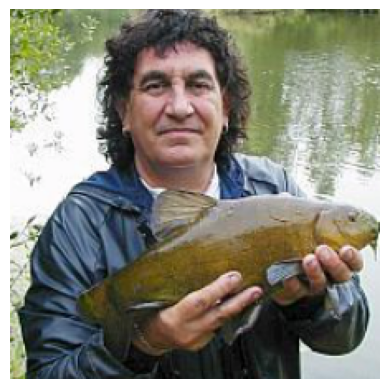

inputs type: <class 'torch.Tensor'>, labels type: <class 'int'>
inputs type: <class 'torch.Tensor'>, labels type: <class 'torch.Tensor'>


In [19]:
import torchvision.transforms.functional as F

valfile_path = "/chtc/PUBLIC/hzhao292/ImageNetMini/val"

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_dataset = RemoteImageFolder(root=valfile_path, transform=val_transforms)


def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

image, label = val_dataset[1]
img = denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_back_to_pil = F.to_pil_image(img)
plt.imshow(img_back_to_pil)
plt.axis('off')  # Hide axes
plt.show()


for inputs, labels in val_dataset:
    print(f"inputs type: {type(inputs)}, labels type: {type(labels)}")
    break
    
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


for inputs, labels in val_loader:
    print(f"inputs type: {type(inputs)}, labels type: {type(labels)}")
    break

# Test Reading Locally

In [20]:
trainfile_path = "../ImageNetMini/train"
valfile_path = "../ImageNetMini/val"

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_dataset = RemoteImageFolder(root=valfile_path, transform=val_transforms)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

for batch_idx, (images, labels) in enumerate(val_loader):
    print(f"Batch {batch_idx}:")
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

    # Optional: Print the first image tensor for verification
    if batch_idx == 0:
        print("Example Image Tensor:")
        print(images[0])
    break


Initializing local dataset from ../ImageNetMini/val
Batch 0:
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Example Image Tensor:
tensor([[[-0.4568, -0.5082, -0.6623,  ...,  0.6563,  0.6734,  0.6734],
         [-0.4739, -0.4568, -0.5424,  ...,  0.6734,  0.6734,  0.6906],
         [-0.3369, -0.3883, -0.5082,  ...,  0.6563,  0.6563,  0.6734],
         ...,
         [-1.0562, -1.0562, -0.9192,  ..., -0.4568, -0.5938, -0.5424],
         [-0.7650, -0.7308, -0.5596,  ..., -0.3027, -0.2856, -0.1999],
         [-0.6281, -0.6452, -0.8678,  ..., -0.4226, -0.2856, -0.3198]],

        [[-0.3025, -0.3550, -0.5126,  ...,  1.3431,  1.3256,  1.3256],
         [-0.3200, -0.3025, -0.3901,  ...,  1.3606,  1.3606,  1.3431],
         [-0.1625, -0.2150, -0.3375,  ...,  1.3782,  1.3431,  1.3431],
         ...,
         [-0.6352, -0.6702, -0.5826,  ...,  0.0301, -0.0749,  0.0476],
         [-0.3375, -0.3725, -0.2150,  ...,  0.1877,  0.2227,  0.3803],
         [-0.2150, -0.2500, -0.